In [142]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

X, y = make_moons (n_samples = 500, noise = 0.15, random_state = 49)
y = y*2-1.0 # convert the labels from {0,1} to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

import matplotlib.pyplot as plt
def plot_svm(clf, X, y, axes=[-2, 3, -2, 2]): 
    """
    Generate a simple plot of SVM including the decision boundary, margin, and its training data
    
    Parameters
    ----------
    clf: your classifier handle
    X: feature matrix shape(m_samples, n_features)
    y: label vector shape(m_samples, )
    axes: (optional) the axes of the plot in format [xmin, xmax, ymin, ymax] 
    """
    # Create a mesh grid based on the provided axes (100 x 100 resolution)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)  # create a mesh grid
    X_mesh = np.c_[x0.ravel(), x1.ravel()]  # convert all mesh points into 2-D points
    y_decision = clf.decision_function(X_mesh).reshape(x0.shape)

    plt.figure(figsize=(16, 9))
    plt.plot(X[:, 0][y == -1], X[:, 1][y == -1], "bo", label="Class -1")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "go", label="Class +1")
    
    # Plot out the support vectors (in red)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, c="r", label="Support Vectors")
    # Plot decision boundary and margins
    plt.contour(x0, x1, y_decision, colors='k',
                levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.legend(loc="lower right")
    plt.axis("auto")

    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    plt.show()


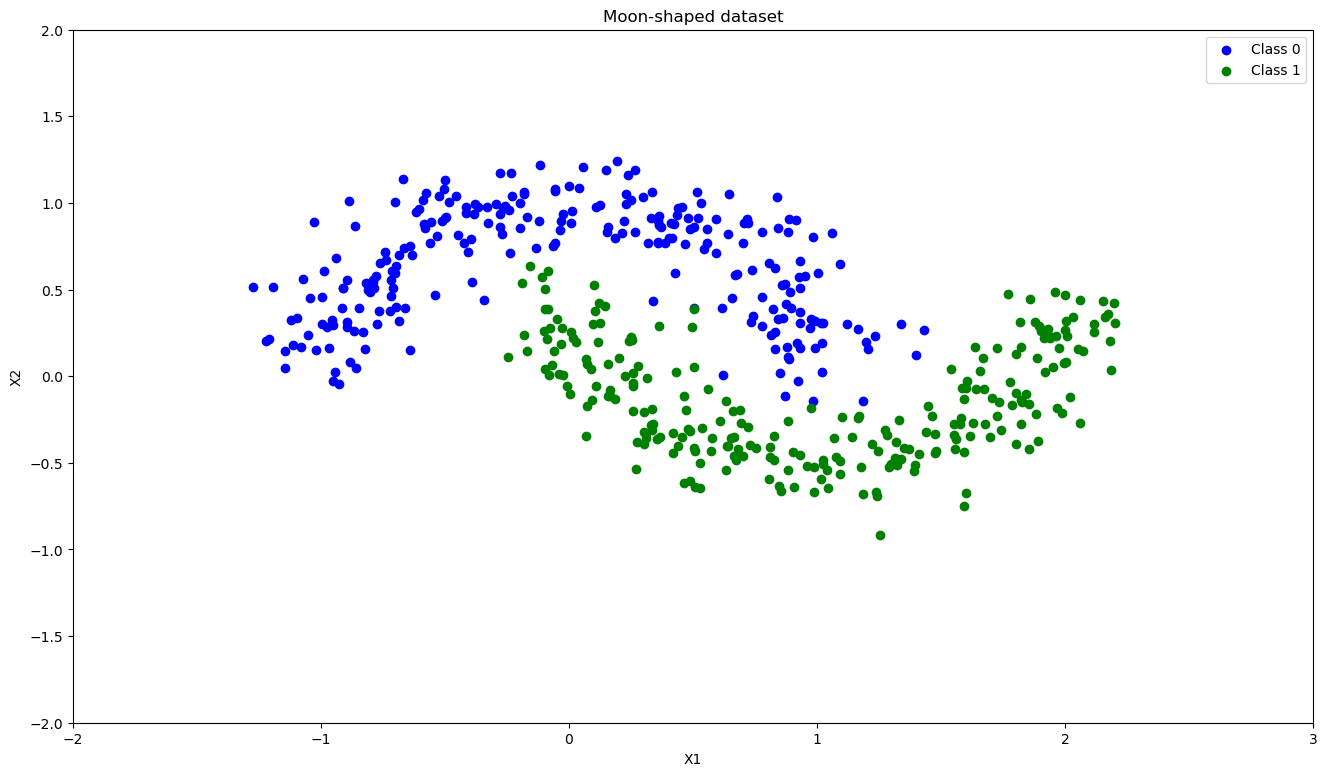

In [155]:

# Plot the dataset
plt.figure(figsize=(16, 9))
X, y = make_moons (n_samples = 500, noise = 0.15, random_state = 49)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='g', label='Class 1')
plt.title("Moon-shaped dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(-2, 2)  
plt.ylim(-2, 2)
plt.yticks([-2, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])
plt.xticks([-2, -1, 0, 1, 2,3])
plt.legend()
plt.show()


In [144]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.stats import randint, uniform
import numpy as np


def tuneAndTest(model, params):
  rnd_search = RandomizedSearchCV(model, param_distributions =params, n_iter = 50, cv = 5, random_state=40)
  rnd_search.fit(X_train, y_train)
  print("best hyper-parameter value: ", rnd_search.best_params_)
  bestmodel = rnd_search.best_estimator_

  #predict
  prediction = bestmodel.predict(X_test)
  # print("model:", str(bestmodel))
  print("confusion matrix:", confusion_matrix(y_test, prediction))
  print("recall:",recall_score(y_test, prediction))
  print("precision:",precision_score(y_test, prediction))
  plot_svm(bestmodel, X_train, y_train)
  print("\n")




best hyper-parameter value:  {'C': 8.153740561605723}
confusion matrix: [[34 11]
 [ 5 50]]
recall: 0.9090909090909091
precision: 0.819672131147541


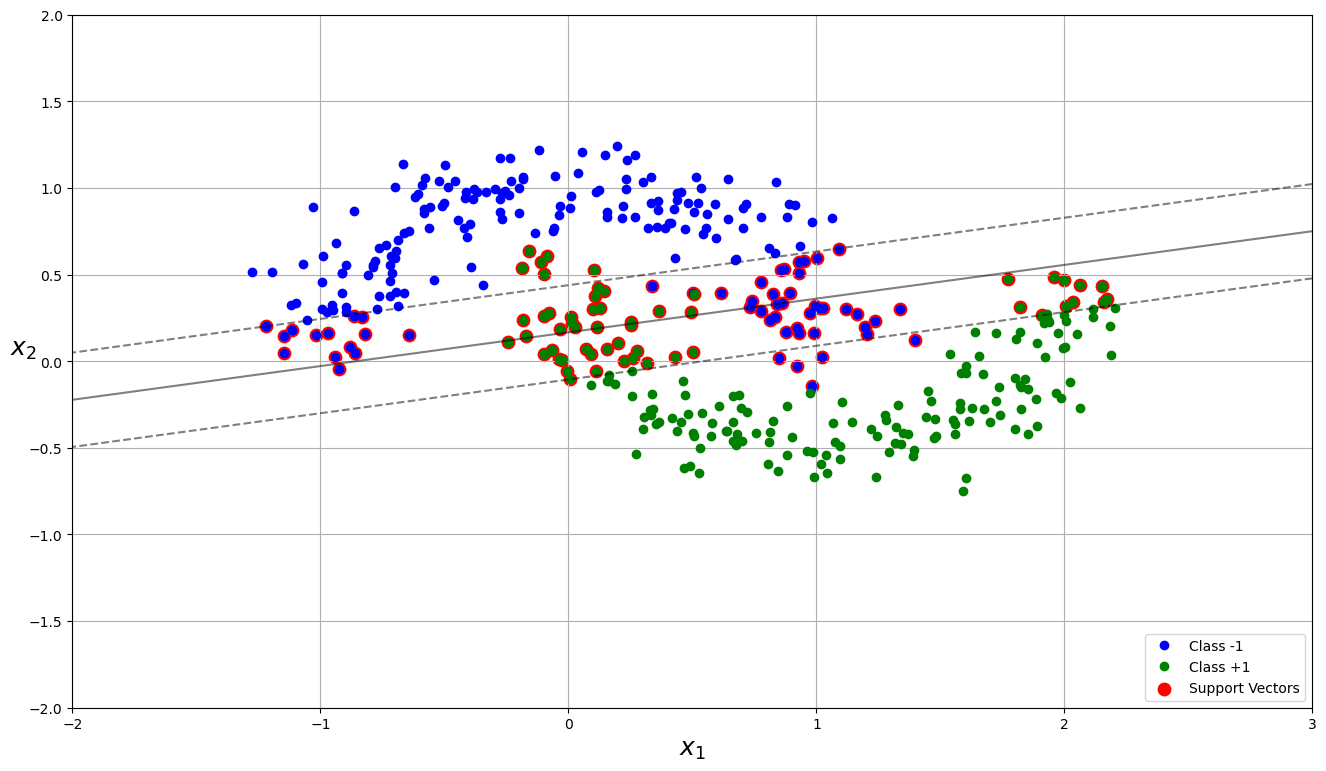

In [145]:
tuneAndTest(SVC(kernel="linear"),{"C": uniform(0,20)})

best hyper-parameter value:  {'C': 7.826529617851785, 'coef0': 3, 'degree': 3, 'gamma': 0.6095896671142067}
confusion matrix: [[42  3]
 [ 0 55]]
recall: 1.0
precision: 0.9482758620689655


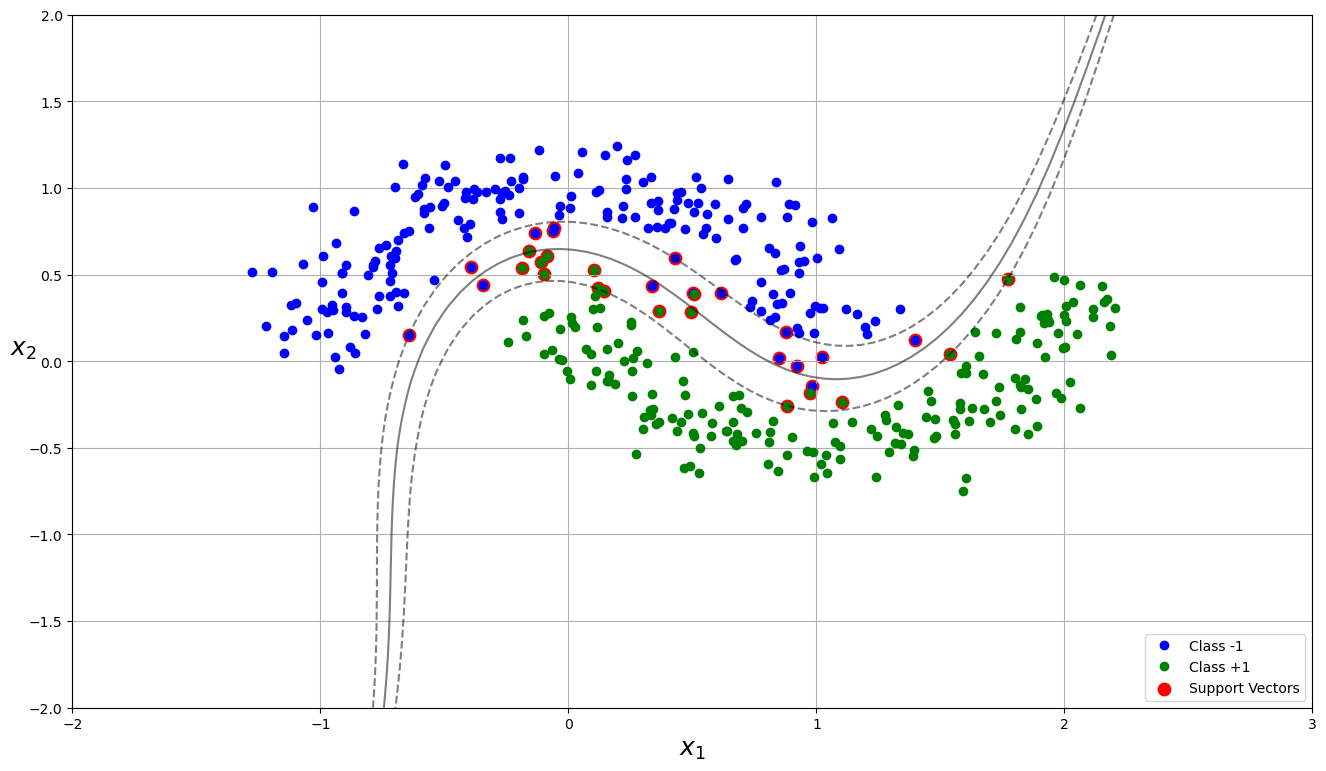

In [146]:
tuneAndTest(SVC(kernel="poly"),{"coef0":randint(low=0, high=5),"C": uniform(0,20),"degree": randint(low=2, high=5), "gamma":uniform(0, 1)})


best hyper-parameter value:  {'C': 10.527990485942908, 'gamma': 0.6238122128846867}
confusion matrix: [[42  3]
 [ 0 55]]
recall: 1.0
precision: 0.9482758620689655


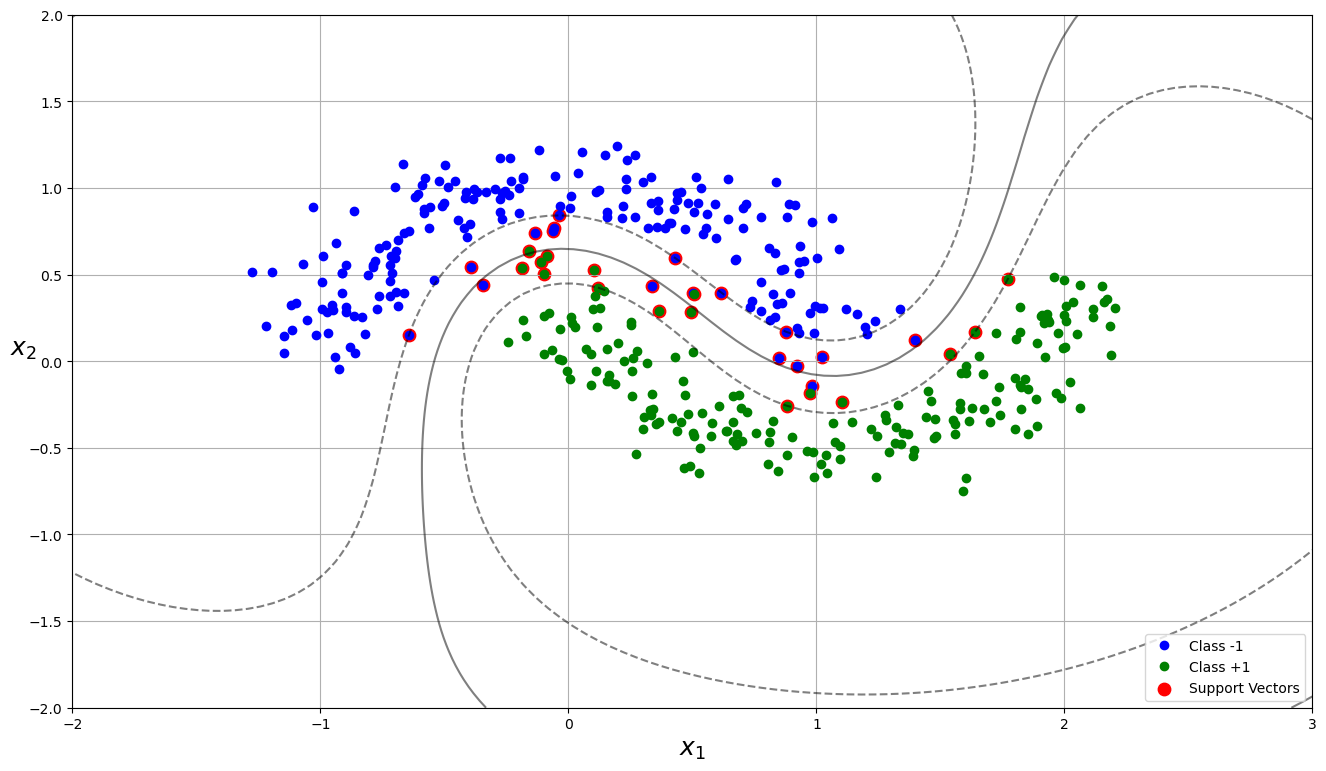

In [147]:
tuneAndTest(SVC(kernel="rbf"),{"C": uniform(0,20), "gamma":uniform(0, 1)})


In [148]:

# Linear Kernel             
def linear_kernel(u, v):
    return np.dot(u, v)

# Polynomial Kernel (of degree up to and including p)
def polynomial_kernel(u, v, p=3):
    return np.dot(u,v)**p

# Gaussian RBF Kernel
def rbf_kernel(u, v, gamma=0.1):
    # Note that gamma is provided, not sigma; see the slides for the relationship between gamma and sigma
    return np.exp(-gamma*np.linalg.norm(u-v)**2)

In [149]:
import cvxopt # The optimization package for Quadratic Programming
import cvxopt.solvers
from sklearn.base import BaseEstimator, ClassifierMixin 
# extending these classes is required by all scikitlearn classes that will need fit, transform, and fit_transform functions
# this is what enables inclusion in pipelines and compatability with other scikitlearn structures and functions

class MySVM(BaseEstimator, ClassifierMixin):
    """The Implementation of the SVM class"""

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel # the kernel function used; this is a function and can be called
        self.C = C # make sure to set this when instantiating this class; is C is None, your performance will be weird
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y=None):
        """
        Train SVM based on the training set
        Parameters
        ----------
        X: feature matrix shape(m_samples, n_features)
        y: label vector shape(m_samples, )
        """
        self.X = X
        self.y = y
        
        m_samples, n_features = X.shape

        # To speed up repeated applications of the kernel function, dynamic programming is used
        # All pairs of points have the kernel function computed over them and the result stored in K
        # K is indexed by indices in X, so K[i,j] = kernel_function(X[i], X[j])
        # You may use K in your code later in this function, but are not required to
        # DO NOT edit this code
        K = np.zeros((m_samples, m_samples))
        for i in range(m_samples):
            for j in range(m_samples):
                K[i,j] = self.kernel(X[i], X[j])


        # This part requires some understanding of Quadratic Programming (QP)
        # Below is the user's guide for the QP from CVXOPT 
        # http://cvxopt.org/userguide/coneprog.html#quadratic-programming
        # DO NOT edit any of this code until Subtask 3
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(m_samples) * -1)
        A = cvxopt.matrix(y, (1,m_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(m_samples) * -1))
            h = cvxopt.matrix(np.zeros(m_samples))
        else:
            tmp1 = np.diag(np.ones(m_samples) * -1)
            tmp2 = np.identity(m_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(m_samples)
            tmp2 = np.ones(m_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers for each point in X
        a = np.ravel(solution['x'])


        # Support vectors have non zero lagrange multipliers
        # sv is a boolean array
        # sv[i] is True iff a[i] is non-zero
        sv = a > 1e-3

        # Find the support vectors
        # note that plot_svm expects self.support_vectors_ to be a numpy array
        # you can use a Python list in your implementation, as long as you cast to a numpy array at the end of this function
        # or, you can cast to a numpy array now
        # you should add lists to store any additional metadata related to each support vector necessary later
        # for example, if you will use the Lagrange multipliers in future calculations... 
        # ...you should add an instance variable which lists the Langrage multipliers for each support vector
        self.support_vectors_ = X[sv]

        print("%d support vectors out of %d points" % (sum(sv), m_samples))

        if self.kernel == linear_kernel:
            ay = (a*y)[:,np.newaxis]
            self.w =  np.dot(ay.T,X).T
    

            # Compute the Weight vector w
        else:
            # No need to compute for w in non-linear case
            # Instead, we will use alpha (a) directly to predict the labels
            self.w = None



        #  Compute the Intercept b
        # b can be computed based on any arbitrary support vector
        # it is recommended that you use self.support_vectors_[0], since this will always exist
        # b should NOT be in terms of w, since w only exists in the linear case

        self.a = a
        self.b = 0
        for i in range(len(a)): 
          if a[i] > 1e-3:
            for j in range(len(X)):
                self.b += a[j] * y[j] * K[i,j]
            self.b += y[i] - self.b
        self.b /= len(X[sv])


    def decision_function(self, X):
        """The decision function is essentially w^T . x + b"""
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            # SUBTASK 6 (25 pts): for non-linear case, implement the kernel trick to predict label here
            # you are predicting one label for each point in X
            # note that this X may differ from the X passed to self.fit
            y_predict = np.zeros(len(X))    
            for i in range (len(X)):
              for j in range (len(self.a)):
                y_predict[i] +=self.a[j] * self.y[j] * self.kernel(self.X[j], X[i])
              y_predict[i] += self.b
            return y_predict


    def predict(self, X):
        """Predicts -1,+1 based on the sign of the decision function"""
        return np.sign(self.decision_function(X))



     pcost       dcost       gap    pres   dres
 0: -5.7855e+02 -1.7691e+04  4e+04  7e-01  4e-14
 1: -4.5535e+02 -4.4529e+03  4e+03  2e-02  2e-14
 2: -6.0289e+02 -1.4379e+03  9e+02  3e-03  2e-14
 3: -7.3065e+02 -1.0600e+03  3e+02  1e-03  2e-14
 4: -7.8022e+02 -9.5918e+02  2e+02  5e-04  2e-14
 5: -8.0913e+02 -9.0561e+02  1e+02  2e-04  2e-14
 6: -8.2120e+02 -8.8377e+02  6e+01  1e-04  2e-14
 7: -8.3144e+02 -8.6567e+02  3e+01  6e-05  2e-14
 8: -8.3841e+02 -8.5497e+02  2e+01  2e-05  2e-14
 9: -8.4240e+02 -8.4859e+02  6e+00  1e-06  2e-14
10: -8.4391e+02 -8.4674e+02  3e+00  6e-07  2e-14
11: -8.4458e+02 -8.4600e+02  1e+00  2e-08  2e-14
12: -8.4504e+02 -8.4550e+02  5e-01  6e-09  2e-14
13: -8.4525e+02 -8.4526e+02  2e-02  2e-10  3e-14
14: -8.4526e+02 -8.4526e+02  2e-03  1e-11  2e-14
15: -8.4526e+02 -8.4526e+02  2e-05  1e-13  3e-14
Optimal solution found.
107 support vectors out of 400 points
mysvm: MySVM(C=8.1537)
confusion matrix: [[37  8]
 [10 45]]
recall: 0.8181818181818182
precision: 0.849056

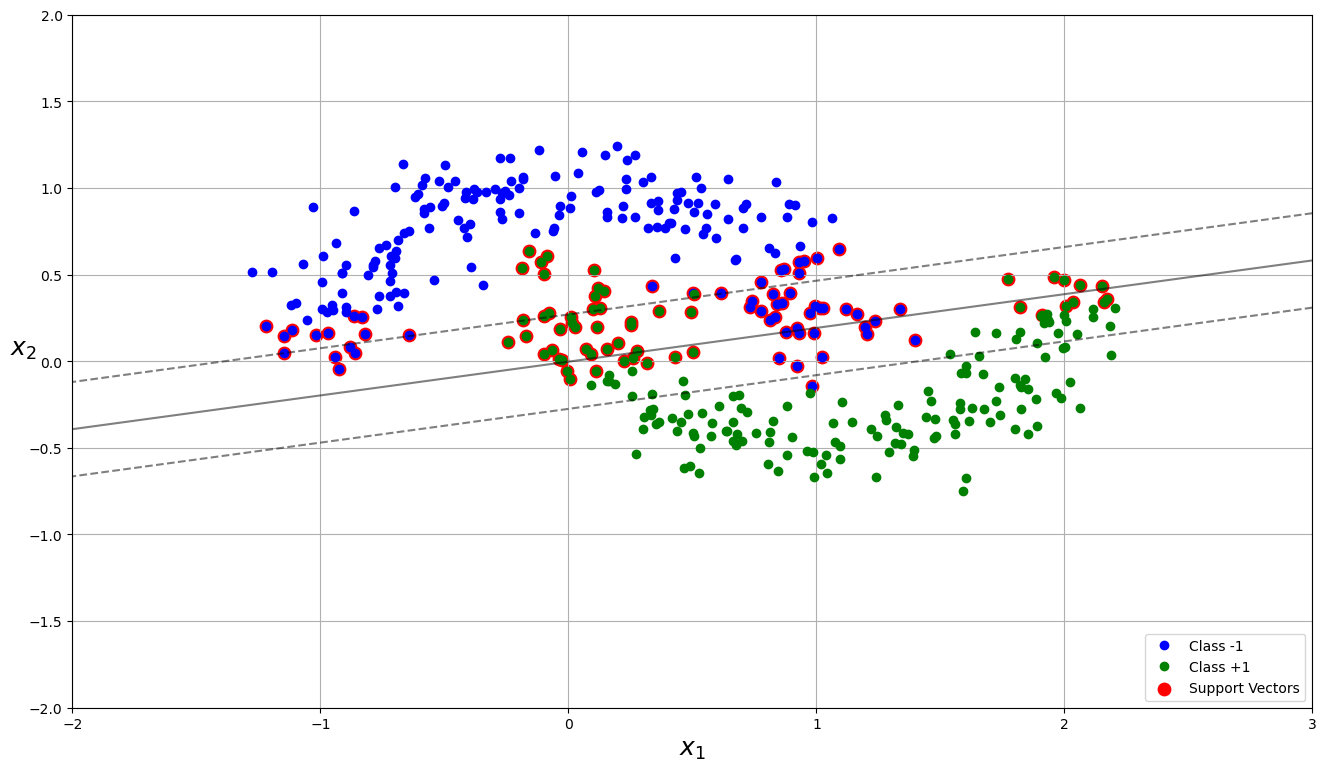



standard library implementation:
confusion matrix: [[34 11]
 [ 5 50]]
recall: 0.9090909090909091
precision: 0.819672131147541


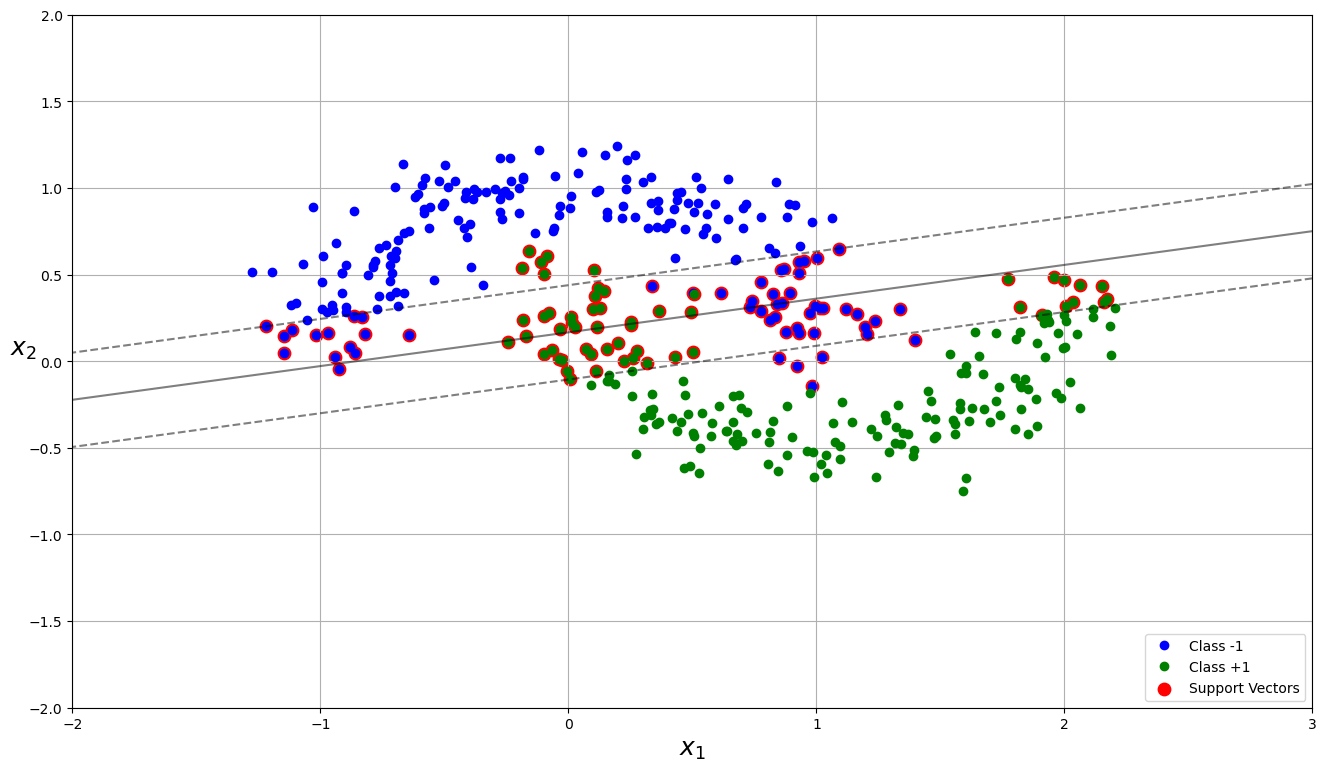

In [150]:

def printResult(model):
  prediction = model.predict(X_test)
  print("confusion matrix:", confusion_matrix(y_test, prediction))
  print("recall:",recall_score(y_test, prediction))
  print("precision:",precision_score(y_test, prediction))
  plot_svm(model, X_train, y_train)
  plt.show()
  print("\n")

def comp(mysvm, lib):
  mysvm.fit(X_train, y_train)
  lib.fit(X_train, y_train)
  print("mysvm:", mysvm)
  printResult(mysvm)
  print("standard library implementation:")
  printResult(lib)


comp(MySVM(C=8.1537),SVC(kernel="linear", C=8.1537))

     pcost       dcost       gap    pres   dres
 0: -2.6488e+02 -2.7126e+03  1e+04  2e+00  6e-14
 1: -1.9728e+02 -1.5658e+03  2e+03  3e-01  5e-14
 2: -1.5606e+02 -6.2187e+02  7e+02  8e-02  4e-14
 3: -1.5562e+02 -2.5375e+02  1e+02  1e-02  3e-14
 4: -1.6328e+02 -2.2879e+02  8e+01  7e-03  2e-14
 5: -1.6792e+02 -2.1452e+02  6e+01  4e-03  2e-14
 6: -1.7392e+02 -1.9318e+02  2e+01  1e-03  2e-14
 7: -1.7496e+02 -1.9071e+02  2e+01  5e-04  2e-14
 8: -1.7774e+02 -1.8558e+02  8e+00  2e-04  3e-14
 9: -1.7958e+02 -1.8228e+02  3e+00  4e-05  2e-14
10: -1.7965e+02 -1.8219e+02  3e+00  4e-05  2e-14
11: -1.8039e+02 -1.8120e+02  8e-01  4e-06  3e-14
12: -1.8074e+02 -1.8077e+02  3e-02  1e-07  3e-14
13: -1.8075e+02 -1.8075e+02  2e-03  7e-09  3e-14
14: -1.8075e+02 -1.8075e+02  3e-05  8e-11  3e-14
Optimal solution found.
101 support vectors out of 400 points
mysvm: MySVM(C=2.0, kernel=<function polynomial_kernel at 0x0000017C60FEC2C0>)
confusion matrix: [[37  8]
 [ 8 47]]
recall: 0.8545454545454545
precision: 0

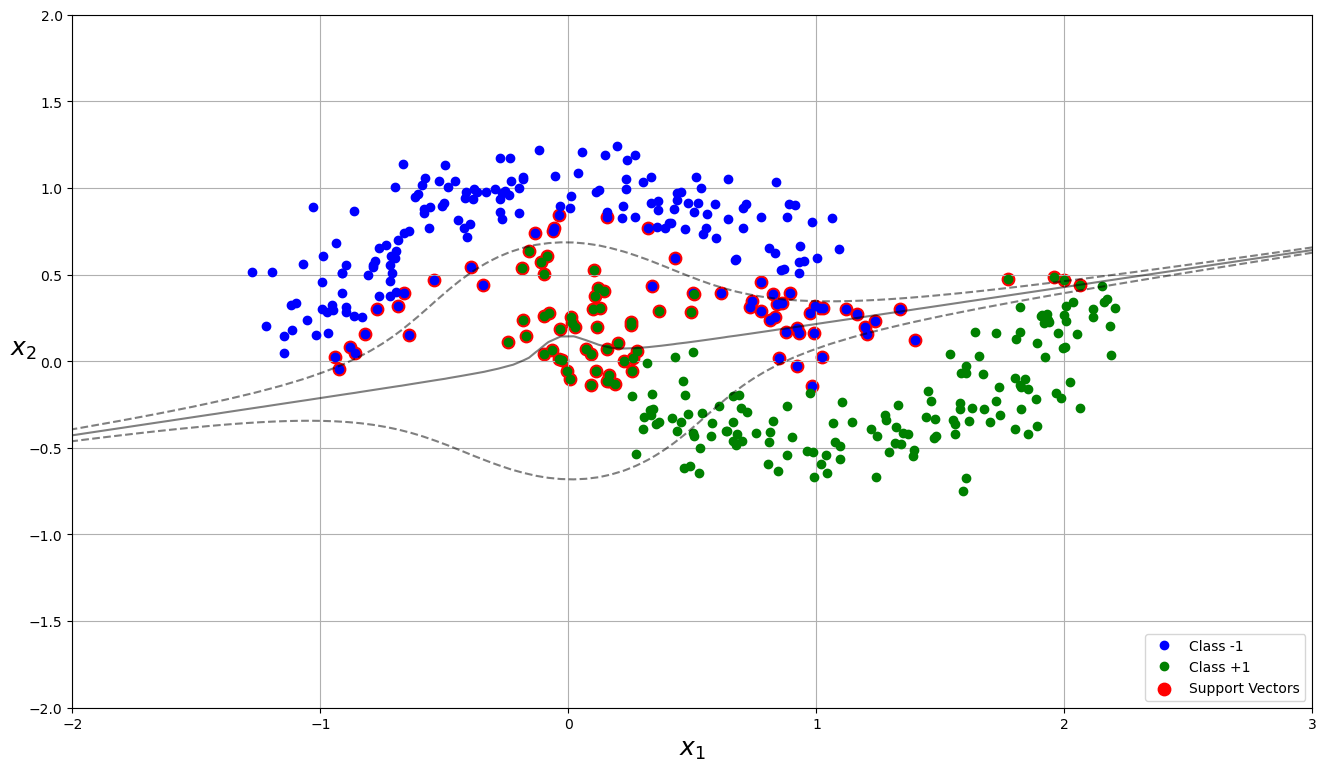



standard library implementation:
confusion matrix: [[35 10]
 [ 1 54]]
recall: 0.9818181818181818
precision: 0.84375


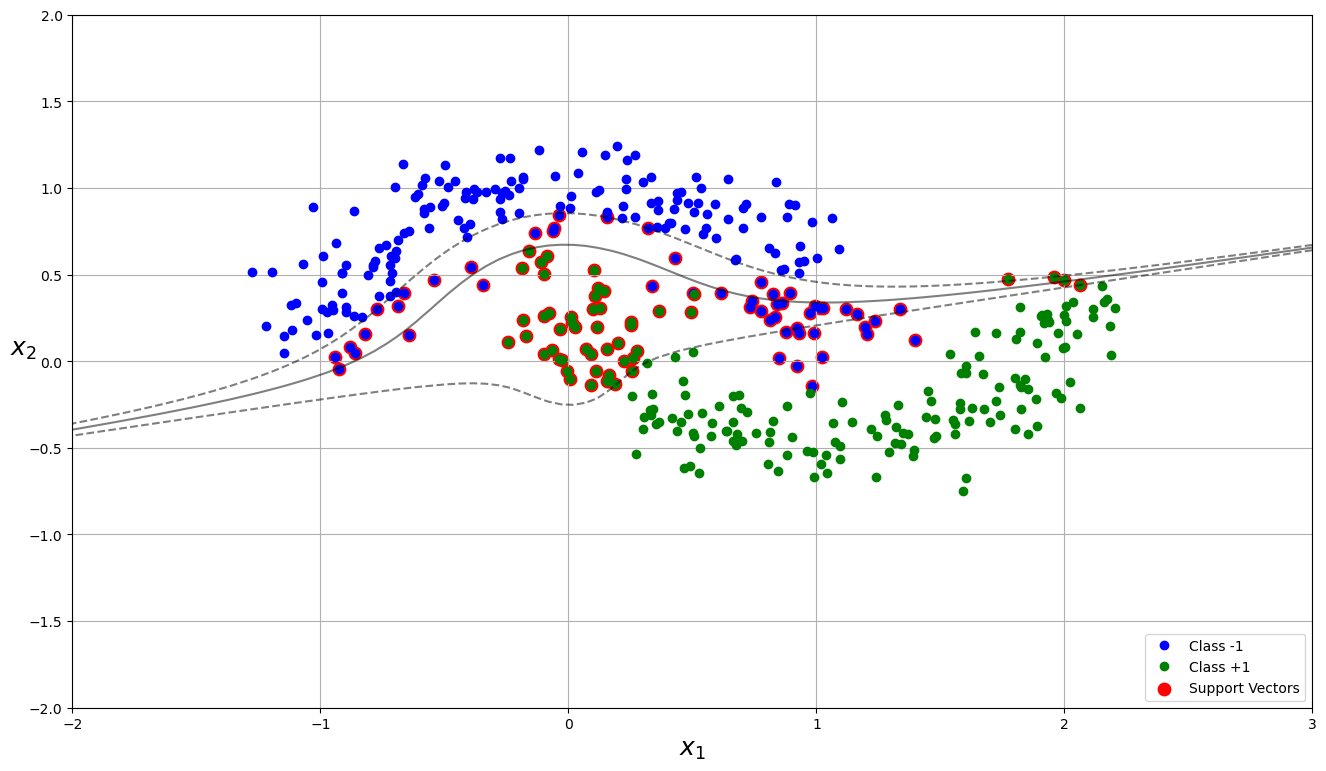

In [151]:
comp(MySVM(C=2,kernel=polynomial_kernel),SVC(C=7.8,kernel="poly", degree=3, gamma = 0.61))

     pcost       dcost       gap    pres   dres
 0: -1.8411e+02 -2.2662e+04  4e+04  4e-01  2e-14
 1: -1.4335e+02 -3.8768e+03  4e+03  4e-03  2e-14
 2: -6.0802e+02 -1.6597e+03  1e+03  8e-04  2e-14
 3: -7.3013e+02 -1.3056e+03  6e+02  4e-04  2e-14
 4: -7.9670e+02 -1.1542e+03  4e+02  2e-04  2e-14
 5: -8.3558e+02 -1.0758e+03  2e+02  9e-05  2e-14
 6: -8.6935e+02 -1.0167e+03  1e+02  4e-05  2e-14
 7: -8.8512e+02 -9.9137e+02  1e+02  3e-05  2e-14
 8: -9.0644e+02 -9.5373e+02  5e+01  7e-06  2e-14
 9: -9.1740e+02 -9.3731e+02  2e+01  2e-06  3e-14
10: -9.2223e+02 -9.3003e+02  8e+00  5e-07  3e-14
11: -9.2477e+02 -9.2654e+02  2e+00  5e-15  3e-14
12: -9.2560e+02 -9.2565e+02  5e-02  2e-14  3e-14
13: -9.2562e+02 -9.2562e+02  8e-04  2e-14  3e-14
Optimal solution found.
109 support vectors out of 400 points
mysvm: MySVM(C=10.5, kernel=<function rbf_kernel at 0x0000017C60FEE3E0>)
confusion matrix: [[37  8]
 [ 3 52]]
recall: 0.9454545454545454
precision: 0.8666666666666667


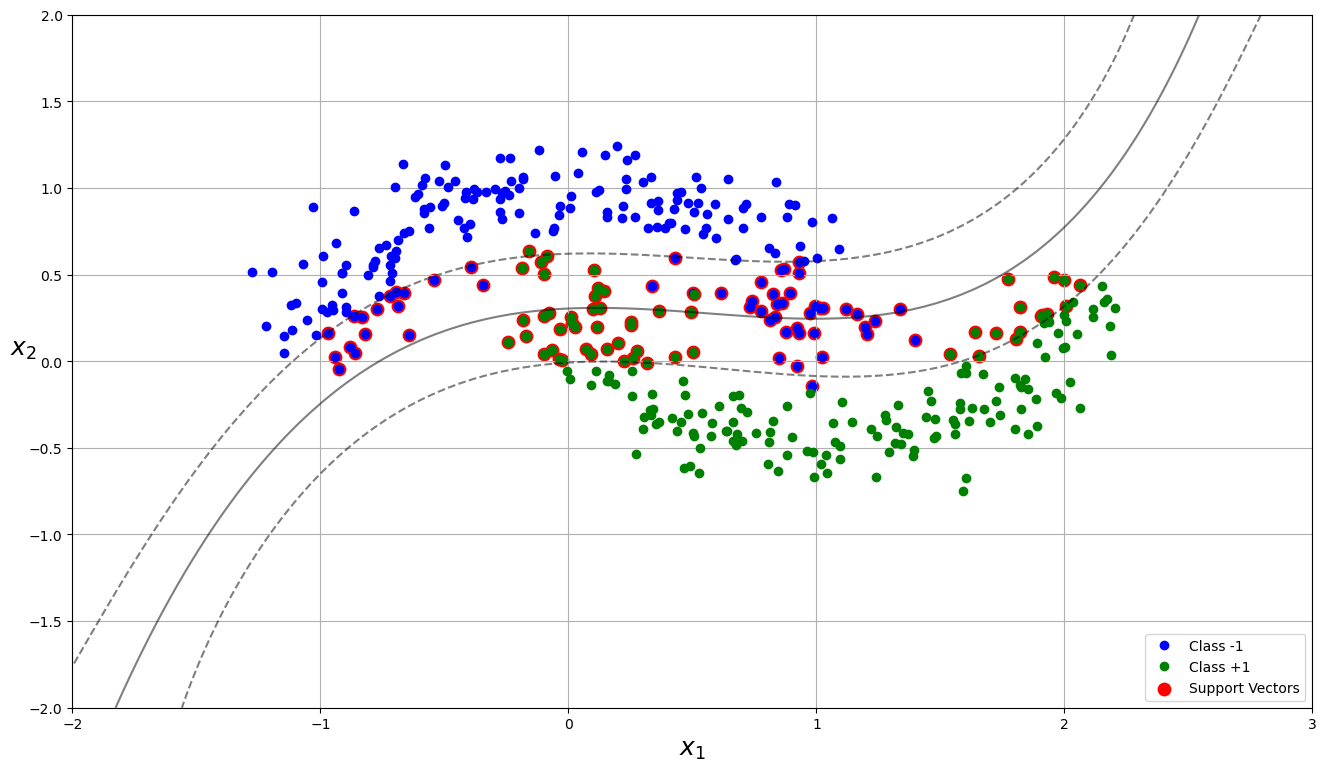



standard library implementation:
confusion matrix: [[42  3]
 [ 0 55]]
recall: 1.0
precision: 0.9482758620689655


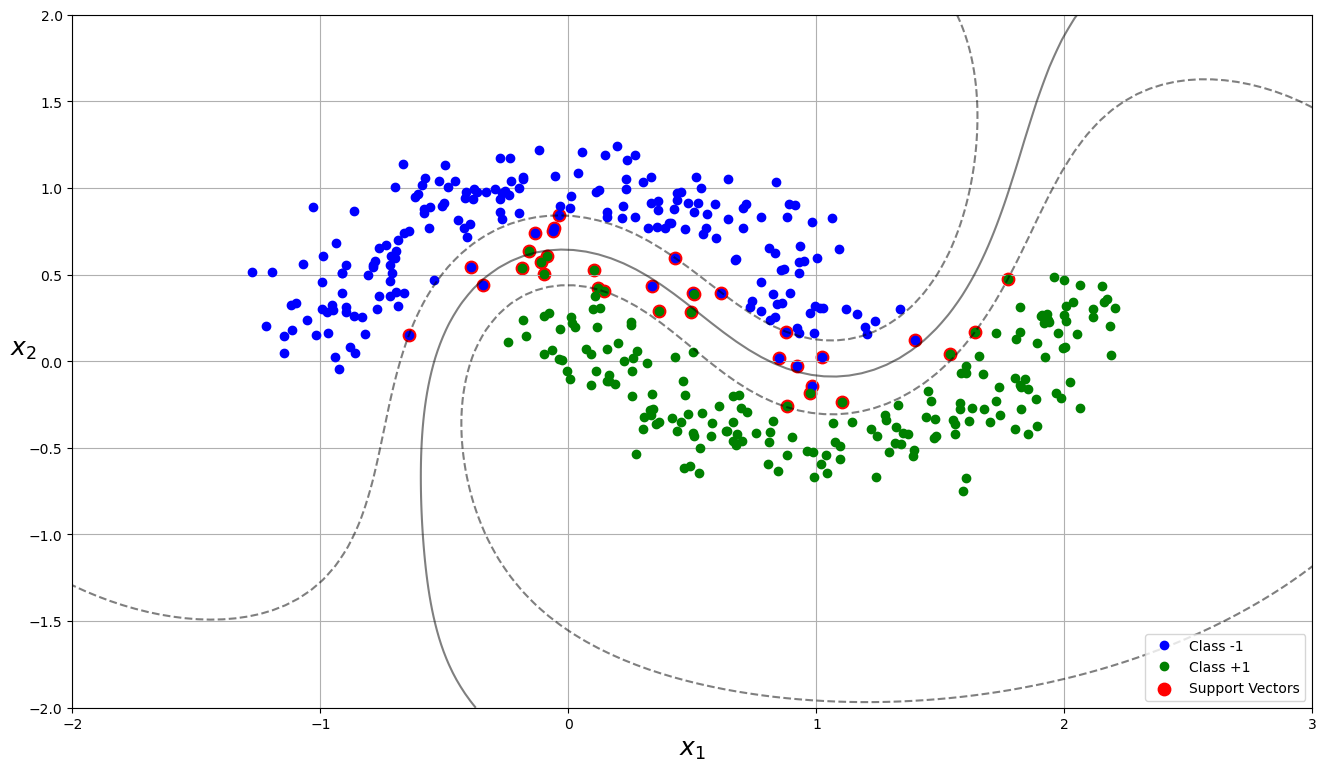

In [152]:
comp(MySVM(C=10.5,kernel=rbf_kernel),SVC(C=10.5,kernel="rbf", gamma = 0.6))



In [153]:
pip install cvxopt


Note: you may need to restart the kernel to use updated packages.
